In [241]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import time

In [39]:
cadr=42

In [40]:
n = 5 # размерность сетки
mat = np.zeros((n * n, n * n), dtype=int)
for i in range(n):
    for j in range(n):
        row = n * j + i
        if i == 0 or i == n - 1 or j == 0 or j == n - 1:
            mat[row][row] = 1
        else:
            mat[row][n * j + i] = 2
            mat[row][n * j + (i - 1)] = 3
            mat[row][n * j + (i + 1)] = 3
            mat[row][n * (j - 1) + i] = 3
            mat[row][n * (j + 1) + i] = 3
            
print(mat)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 2 3 0 0 

In [229]:
def transform(A, b):
    m = len(A)
    B = np.zeros((m, m))
    C = np.zeros(m)
    for i in range(m):
        for j in range(m):
            if i == j:
                B[i][j] = 0
            else:
                B[i][j] = - A[i][j] / A[i][i]
    for i in range(m):
        C[i] = b[i] / A[i][i]

    return B, C


def seidel_solve(B, C, x):
    m = len(x)
    result = np.zeros(m)
    for i in range(m):
        s = 0
        for j in range(i):
            s += B[i][j] * result[j]
        for j in range(i, m):
            s += B[i][j] * x[j]
        result[i] = s + C[i]
    return result


def Seidel(A, b, eps):
    B, C = transform(A, b)
    x = np.zeros(len(A))
    y = seidel_solve(B, C, x)
    n = 1
    r0 = np.linalg.norm(A @ x - b)
    rn = np.linalg.norm(A @ y - b)
    while rn / r0 > eps and n < 200:
        x = y
        y = seidel_solve(B, C, x)
        rn = np.linalg.norm(A @ y - b)
        n += 1
    return y

def Seidel2(A, b, tol, max_iterations):
    n = len(b)
    x = np.zeros_like(b, dtype=np.float64)  # начальное приближение (нулевой вектор)
    
    for iteration in range(max_iterations):
        x_new = np.copy(x)
        
        # Обновление каждого элемента x
        for i in range(n):
            # Сумма по известным значениям с использованием обновленных элементов
            s1 = np.dot(A[i, :i], x_new[:i])
            # Сумма по оставшимся элементам с использованием старых значений
            s2 = np.dot(A[i, i + 1:], x[i + 1:])
            
            x_new[i] = (b[i] - s1 - s2) / A[i, i]
        
        # Проверка условия сходимости
        if np.linalg.norm(x_new - x, ord=np.inf) < tol:
            print(f"Решение найдено за {iteration + 1} итераций")
            return x_new
        
        x = x_new

In [262]:
T = 0.1
field_size = 200
time_duration = 100

t = T / time_duration
h = 1 / field_size
u = np.zeros((field_size, field_size, int(T / t)))
eps = 10 ** -5

In [263]:
def phi(x, y):
    return np.sin(x + y)

def g(x, y, t):
    return np.cos(x + y)

In [264]:
# Ника сделать это по человечески, рассмотреть все граничные условия дял матрицы и переписать весь код по человечсеский
def generate_matrix(n, h, t):
    A = np.zeros((n * n, n * n))
    for i in range(n):
        for j in range(n):
            row = n * j + i
            if i == 0 or i == n - 1 or j == 0 or j == n - 1:
                A[row][row] = 1
            else:
                A[row][n * j + i] = (h ** 2 + 4 * t)
                A[row][n * j + (i - 1)] = -t
                A[row][n * j + (i + 1)] = -t
                A[row][n * (j - 1) + i] = -t
                A[row][n * (j + 1) + i] = -t
    return A

def generate_b(u, n, h, t, k):
    # b = np.zeros(n * n)
    # for i in range(n):
    #     for j in range(n):
    #         row = j * n + i
    #         if i == 0 or i == n - 1 or j == 0 or j == n - 1:
    #             b[row] = g(i * h, j * h, k * t)
    #         else:
    #             b[row] = h ** 2 * u[i][j][k]
    b = np.zeros((n, n))

    # Массив для индексации граничных элементов
    boundary_mask = np.zeros((n, n), dtype=bool)
    boundary_mask[0, :] = boundary_mask[-1, :] = True
    boundary_mask[:, 0] = boundary_mask[:, -1] = True
    
    # Массив для индексации внутренних элементов
    inner_mask = ~boundary_mask
    
    # Заполняем граничные элементы с использованием функции g
    i, j = np.where(boundary_mask)
    b[boundary_mask] = g(i * h, j * h, k * t)
    
    # Заполняем внутренние элементы с использованием u и h
    b[inner_mask] = h ** 2 * u[inner_mask][:, k]
    
    # Разворачиваем матрицу b в одномерный массив
    b = b.ravel()
    
    return b

In [265]:
def solve():
    A = generate_matrix(field_size, h, t)
    A = csr_matrix(A)
    # np.set_printoptions(threshold=np.inf)
    # print(A)
    for k in range(0, int(T / t)):
        if k == 0:
            for i in range(field_size):
                for j in range(field_size):
                    if i == 0 or j == 0 or i == field_size - 1 or j == field_size - 1:
                        u[i][j][k] = g(i * h, j * h, 0)
                    else:
                        u[i][j][k] = phi(i * h, j * h)
        else:  
            cur_time = time.time()
            b = generate_b(u, field_size, h, t, k - 1)
            # print(b)
            # np.set_printoptions(threshold=np.inf, linewidth=np.inf)
            # print(A)
            y = spsolve(A, b)
            print(f'кадр {k}, time = {time.time() - cur_time}')
            u[:, :, k] = y.reshape(field_size, field_size)
                    

In [266]:
solve()

кадр 1, time = 0.17938661575317383
кадр 2, time = 0.15120315551757812
кадр 3, time = 0.21332907676696777
кадр 4, time = 0.17471885681152344
кадр 5, time = 0.16457581520080566
кадр 6, time = 0.15261054039001465
кадр 7, time = 0.1671757698059082
кадр 8, time = 0.16900181770324707
кадр 9, time = 0.16511869430541992
кадр 10, time = 0.1685926914215088
кадр 11, time = 0.1574239730834961
кадр 12, time = 0.15729689598083496
кадр 13, time = 0.16426706314086914
кадр 14, time = 0.1527576446533203
кадр 15, time = 0.15739083290100098
кадр 16, time = 0.14942479133605957
кадр 17, time = 0.15102052688598633
кадр 18, time = 0.15119385719299316
кадр 19, time = 0.15393280982971191
кадр 20, time = 0.15146470069885254
кадр 21, time = 0.15524554252624512
кадр 22, time = 0.15358662605285645
кадр 23, time = 0.1728532314300537
кадр 24, time = 0.15474820137023926
кадр 25, time = 0.15122532844543457
кадр 26, time = 0.1480414867401123
кадр 27, time = 0.15177464485168457
кадр 28, time = 0.14865350723266602
кадр 29

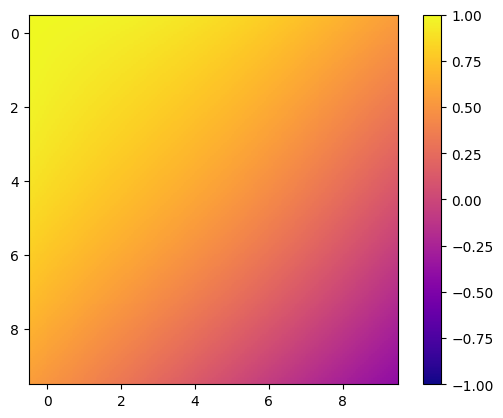

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Задаем параметры
frames = time_duration - 10  # Количество кадров анимации
interval = 100  # Интервал между кадрами в миллисекундах
 
# Создание фигуры и оси
fig, ax = plt.subplots()

data = np.random.rand(10, 10)

# Создание начальной тепловой карты
heatmap = ax.imshow(data, cmap='plasma', interpolation='nearest', vmin = -1, vmax = 1)

# Функция обновления для анимации
k = 0

def update(frame):
    global k
    heatmap.set_array(u[:, :, k])
    k += 1
    # print(u[:, :, k])
    return [heatmap]

plt.colorbar(heatmap)

# Создание анимации

ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(f'tryis delete after/animation{cadr}.gif', writer=PillowWriter(fps=10))
cadr += 1
